#**Imports**

run this cell twice for installation and import to be complete

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import poisson
try:
  from empiricaldist import Pmf
except:
  %pip install empiricaldist
import matplotlib.pyplot as plt
from scipy.stats import gamma

#**Poisson Processes**
This chapter introduces the Poisson process, which is a model used to describe events that occur at random intervals. As an example of a Poisson process, we’ll model goal-scoring in soccer, which is American English for the game everyone else calls “football”. We’ll use goals scored in a game to estimate the parameter of a Poisson process; then we’ll use the posterior distribution to make predictions.

And we’ll solve The World Cup Problem.

#**The World Cup Problem**
In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2. Based on this outcome:

* How confident should we be that France is the better team?

* If the same teams played again, what is the chance France would win again?

To answer these questions, we have to make some modeling decisions.

* First, I’ll assume that for any team against another team there is some unknown goal-scoring rate, measured in goals per game, which I’ll denote with the Python variable lam or the Greek letter λ, pronounced “lambda”.

* Second, I’ll assume that a goal is equally likely during any minute of a game. So, in a 90 minute game, the probability of scoring during any minute is λ/90.

* Third, I’ll assume that a team never scores twice during the same minute.

Of course, none of these assumptions is completely true in the real world, but I think they are reasonable simplifications. As George Box said, “All models are wrong; some are useful.” (https://en.wikipedia.org/wiki/All_models_are_wrong).

In this case, the model is useful because if these assumptions are true, at least roughly, the number of goals scored in a game follows a Poisson distribution, at least roughly.

## **The Poisson Distribution**
If the number of goals scored in a game follows a Poisson distribution with a goal-scoring rate, λ, the probability of scoring k goals is:

\begin{equation}
P=\frac{λ^kexp(−λ)}{k!}
\end{equation}

for any non-negative value of $k$.
SciPy provides a poisson object that represents a Poisson distribution. We can create one with λ=1.4 like this:

In [8]:
lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

The result is an object that represents a “frozen” random variable and provides `pmf`, which evaluates the probability mass function of the Poisson distribution.

In [9]:
k = 4
dist.pmf(k)

0.039471954028253146

This result implies that if the average goal-scoring rate is 1.4 goals per game, the probability of scoring 4 goals in a game is about 4%.

We’ll use the following function to make a Pmf that represents a Poisson distribution.

In [10]:
def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

`make_poisson_pmf` takes as parameters the goal-scoring rate, lam, and an array of quantities, qs, where it should evaluate the Poisson PMF. It returns a Pmf object.

For example, here’s the distribution of goals scored for `lam=1.4`, computed for values of `k` from `0` to `9`.

In [11]:
lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

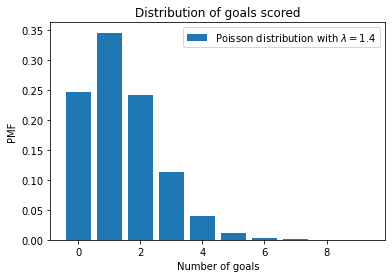

In [12]:
plt.xlabel('Number of goals')
plt.ylabel('PMF')
plt.title('Distribution of goals scored')
pmf_goals.bar()
plt.legend(['Poisson distribution with $\lambda=1.4$'])

The most likely outcomes are 0, 1, and 2; higher values are possible but increasingly unlikely. Values above 7 are negligible. This distribution shows that if we know the goal scoring rate, we can predict the number of goals.

Now let’s turn it around: given a number of goals, what can we say about the goal-scoring rate?

To answer that, we need to think about the prior distribution of lam, which represents the range of possible values and their probabilities before we see the score.

## **The Gamma Distribution**
If you have ever seen a soccer game, you have some information about lam. In most games, teams score a few goals each. In rare cases, a team might score more than 5 goals, but they almost never score more than 10.

Using data from previous World Cups, I estimate that each team scores about 1.4 goals per game, on average. So I’ll set the mean of lam to be 1.4.

For a good team against a bad one, we expect lam to be higher; for a bad team against a good one, we expect it to be lower.

To model the distribution of goal-scoring rates, I’ll use a gamma distribution, which I chose because:

1. The goal scoring rate is continuous and non-negative, and the gamma distribution is appropriate for this kind of quantity.

2. The gamma distribution has only one parameter, alpha, which is the mean. So it’s easy to construct a gamma distribution with the mean we want.

3. As we’ll see, the shape of the gamma distribution is a reasonable choice, given what we know about soccer.

And there’s one more reason, which I will reveal in <<_ConjugatePriors>>.

SciPy provides gamma, which creates an object that represents a gamma distribution. And the gamma object provides provides pdf, which evaluates the **probability density function** (PDF) of the gamma distribution.

Here’s how we use it.

In [13]:
alpha = 1.4 #mean
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

The parameter, alpha, is the mean of the distribution. The qs are possible values of lam between 0 and 10. The ps are probability densities, which we can think of as unnormalized probabilities.

To normalize them, we can put them in a Pmf and call `normalize`:

In [14]:
prior = Pmf(ps, qs)
prior.normalize()

9.889360237140306

The result is a discrete approximation of a gamma distribution. Here’s what it looks like.

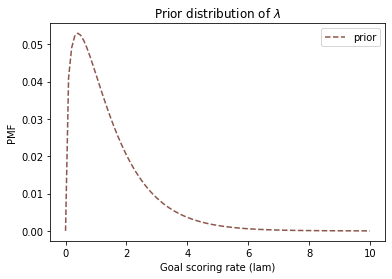

In [15]:
prior.plot(style='--', color='C5')
plt.xlabel('Goal scoring rate (lam)')
plt.ylabel('PMF')
plt.title('Prior distribution of $\lambda$')
plt.legend(['prior'])

This distribution represents our prior knowledge about goal scoring: lam is usually less than 2, occasionally as high as 6, and seldom higher than that.

And we can confirm that the mean is about 1.4.

In [16]:
prior.mean()

1.4140818156118378

As usual, reasonable people could disagree about the details of the prior, but this is good enough to get started. Let’s do an update.

## **The Update**
Suppose you are given the goal-scoring rate, λ, and asked to compute the probability of scoring a number of goals, k. That is precisely the question we answered by computing the Poisson PMF.

For example, if $λ$ is $1.4$, the probability of scoring 4 goals in a game is:

In [17]:
lam = 1.4
k = 4
poisson(lam).pmf(k)

0.039471954028253146

Now suppose we are have an array of possible values for λ; we can compute the likelihood of the data for each hypothetical value of lam, like this:

In [18]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

And that’s all we need to do the update. To get the posterior distribution, we multiply the prior by the likelihoods we just computed and normalize the result.

The following function encapsulates these steps.

In [19]:
def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

The first parameter is the prior; the second is the number of goals.

In the example, France scored 4 goals, so I’ll make a copy of the prior and update it with the data.

In [20]:
france = prior.copy()
update_poisson(france, 4)

Text(0, 0.5, 'PMF')

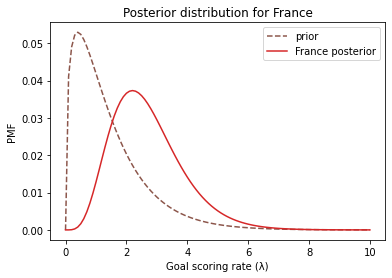

In [21]:
prior.plot(style='--', label='prior', color='C5')
france.plot(label='France posterior', color='C3')

plt.title('Posterior distribution for France')
plt.legend(['prior','France posterior'])
plt.xlabel('Goal scoring rate (λ)')
plt.ylabel('PMF')

The data, `k=4`, makes us think higher values of lam are more likely and lower values are less likely. So the posterior distribution is shifted to the right.

Let’s do the same for Croatia:

In [22]:
croatia = prior.copy()
update_poisson(croatia, 2)

Text(0, 0.5, 'PMF')

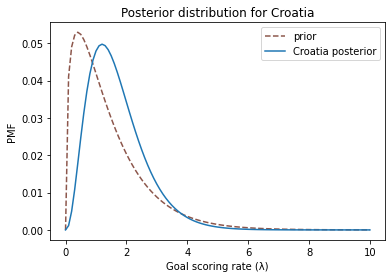

In [23]:
prior.plot(style='--', label='prior', color='C5')
croatia.plot(label='Croatia posterior', color='C0')
plt.title('Posterior distribution for Croatia')
plt.legend(['prior','Croatia posterior'])
plt.xlabel('Goal scoring rate (λ)')
plt.ylabel('PMF')

Here are the posterior means for these distributions.

In [24]:
print(croatia.mean(), france.mean())

1.6999765866755225 2.699772393342308


The mean of the prior distribution is about 1.4. After Croatia scores 2 goals, their posterior mean is 1.7, which is near the midpoint of the prior and the data. Likewise after France scores 4 goals, their posterior mean is 2.7.

These results are typical of a Bayesian update: the location of the posterior distribution is a compromise between the prior and the data.

## **Probability of Superiority**

Now that we have a posterior distribution for each team, we can answer the first question: How confident should we be that France is the better team?

In the model, “better” means having a higher goal-scoring rate against the opponent. We can use the posterior distributions to compute the probability that a random value drawn from France’s distribution exceeds a value drawn from Croatia’s.

One way to do that is to enumerate all pairs of values from the two distributions, adding up the total probability that one value exceeds the other.

In [25]:
def prob_gt(pmf1, pmf2):
    """Compute the probability of superiority."""
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

In [26]:
prob_gt(france, croatia)

0.7499366290930155

In [27]:
Pmf.prob_gt(france, croatia)

0.7499366290930174

The results are slightly different because Pmf.prob_gt uses array operators rather than for loops.

Either way, the result is close to 75%. So, on the basis of one game, we have moderate confidence that France is actually the better team.

Of course, we should remember that this result is based on the assumption that the goal-scoring rate is constant. In reality, if a team is down by one goal, they might play more aggressively toward the end of the game, making them more likely to score, but also more likely to give up an additional goal.

As always, the results are only as good as the model.

## **Predicting the Rematch**

Now we can take on the second question: If the same teams played again, what is the chance Croatia would win? To answer this question, we’ll generate the “posterior predictive distribution”, which is the number of goals we expect a team to score.

If we knew the goal scoring rate, `lam`, the distribution of goals would be a Poisson distribution with parameter `lam`. Since we don’t know `lam`, the distribution of goals is a mixture of a Poisson distributions with different values of `lam`.
First I’ll generate a sequence of `Pmf` objects, one for each value of `lam`.

In [28]:
pmf_seq = [make_poisson_pmf(lam, goals) 
           for lam in prior.qs]

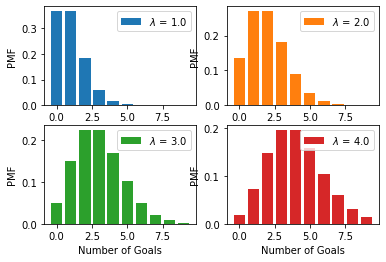

In [29]:
for i, index in enumerate([10, 20, 30, 40]):
    plt.subplot(2, 2, i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label=f'$\lambda$ = {lam}', color=f'C{i}')
    plt.xlabel('Number of Goals')
    plt.ylabel('PMF')
    plt.legend()

The predictive distribution is a mixture of these Pmf objects, weighted with the posterior probabilities. We can use make_mixture from <<_GeneralMixtures>> to compute this mixture.

In [30]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

In [31]:
pred_france = make_mixture(france, pmf_seq)

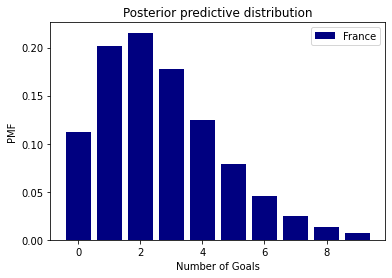

In [32]:
pred_france.bar(color='navy', label='France')
plt.title('Posterior predictive distribution')
plt.xlabel('Number of Goals')
plt.ylabel('PMF')
plt.legend()

In [33]:
pred_croatia = make_mixture(croatia, pmf_seq)

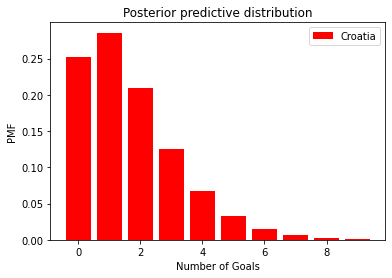

In [34]:
pred_croatia.bar(color='red', label='Croatia')
plt.title('Posterior predictive distribution')
plt.xlabel('Number of Goals')
plt.ylabel('PMF')
plt.legend()

In [35]:
win = Pmf.prob_gt(pred_france, pred_croatia)
win

0.5703522415934519

In [36]:
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose

0.26443376257235873

In [37]:
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

0.16521399583418947

Assuming that France wins half of the ties, their chance of winning the rematch is about 65%

In [38]:
win + tie/2

0.6529592395105466

Text(0.5, 1.0, "France's chances")

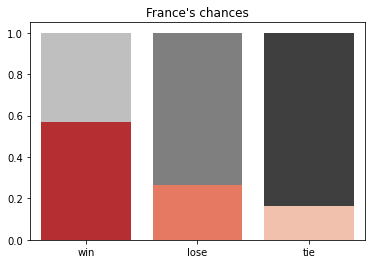

In [39]:
sns.barplot(x=['win','lose','tie'],y=[1.0,1.0,1.0],palette='gray_r')

sns.barplot(x=['win','lose','tie'],y=[win,lose,tie],palette='Reds_r')

plt.title("France's chances")

## **The Exponential Distribution**

As an exercise at the end of this notebook, you’ll have a chance to work on the following variation on the World Cup Problem:

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

In this version, notice that the data is not the number of goals in a fixed period of time, but the time between goals.

To compute the likelihood of data like this, we can take advantage of the theory of Poisson processes again. If each team has a constant goal-scoring rate, we expect the time between goals to follow an exponential distribution.

If the goal-scoring rate is λ, the probability of seeing an interval between goals of $t$ is proportional to the PDF of the exponential distribution:

\begin{equation}
λ×\text{exp}(-λ×t)
\end{equation}

Because $t$ is a continuous quantity, the value of this expression is not a probability; it is a probability density. However, it is proportional to the probability of the data, so we can use it as a likelihood in a Bayesian update.

SciPy provides expon, which creates an object that represents an exponential distribution. However, it does not take lam as a parameter in the way you might expect, which makes it awkward to work with. Since the PDF of the exponential distribution is so easy to evaluate, I’ll use my own function.

In [40]:
def expo_pdf(t, lam):
    """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)

In [41]:
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

25.616650745459093

In [42]:
def decorate_time(title=''):
    plt.xlabel('Time between goals (games)')
    plt.ylabel('PMF')
    plt.title(title)

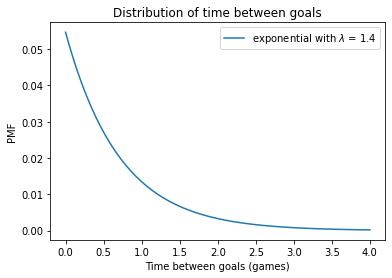

In [43]:
pmf_time.plot(label='exponential with $\lambda$ = 1.4')

decorate_time('Distribution of time between goals')
plt.legend()

It is counterintuitive, but true, that the most likely time to score a goal is immediately. After that, the probability of each successive interval is a little lower.

With a goal-scoring rate of 1.4, it is possible that a team will take more than one game to score a goal, but it is unlikely that they will take more than two games.

# **Summary**
This chapter introduces three new distributions, so it can be hard to keep them straight. Let’s review:

* If a system satisfies the assumptions of a Poisson model, the number of events in a period of time follows a Poisson distribution, which is a discrete distribution with integer quantities from 0 to infinity. In practice, we can usually ignore low-probability quantities above a finite limit.

* Also under the Poisson model, the interval between events follows an exponential distribution, which is a continuous distribution with quantities from 0 to infinity. Because it is continuous, it is described by a probability density function (PDF) rather than a probability mass function (PMF). But when we use an exponential distribution to compute the likelihood of the data, we can treat densities as unnormalized probabilities.

* The Poisson and exponential distributions are parameterized by an event rate, denoted λ or lam.

* For the prior distribution of λ, I used a gamma distribution, which is a 
continuous distribution with quantities from 0 to infinity, but I approximated it with a discrete, bounded PMF. The gamma distribution has one parameter, denoted α or alpha, which is also its mean.

I chose the gamma distribution because the shape is consistent with our background knowledge about goal-scoring rates. There are other distributions we could have used; however, we will see in <<_ConjugatePriors>> that the gamma distribution can be a particularly good choice.

But we have a few things to do before we get there, starting with these exercises.

# **Exercise**

### **Exercise-1 :** 
Let’s finish the exercise we started:

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Here are the steps I recommend:

* Starting with the same gamma prior we used in the previous problem, compute the likelihood of scoring a goal after 11 minutes for each possible value of lam. Don’t forget to convert all times into games rather than minutes.

* Compute the posterior distribution of lam for Germany after the first goal.

* Compute the likelihood of scoring another goal after 12 more minutes and do another update. Plot the prior, posterior after one goal, and posterior after two goals.

* Compute the posterior predictive distribution of goals Germany might score during the remaining time in the game, 90-23 minutes. Note: You will have to think about how to generate predicted goals for a fraction of a game.

* Compute the probability of scoring 5 or more goals during the remaining time.

In [44]:
# Here's a function that updates the distribution of lam
# with the given time between goals

def update_expo(pmf, data):
    """Update based on an observed interval
    
    pmf: prior PMF
    data: time between goals in minutes
    """
    t = data / 90
    lams = pmf.qs
    likelihood = expo_pdf(t, lams)
    pmf *= likelihood
    pmf.normalize()

In [45]:
# Here are the updates for the first and second goals

germany = prior.copy()
update_expo(germany, 11)

germany2 = germany.copy()
update_expo(germany2, 12)

In [49]:
germany.mean(), germany2.mean()

(2.1358882653086892, 2.703059034926364)

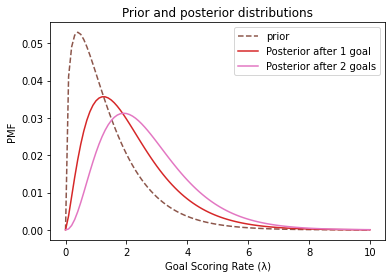

In [54]:
# Here's what the posterior distributions look like

prior.plot(ls='--', label='prior', color='C5')
germany.plot(color='C3', label='Posterior after 1 goal')
germany2.plot(color='C16', label='Posterior after 2 goals')

plt.title('Prior and posterior distributions')
plt.xlabel('Goal Scoring Rate (λ)')
plt.ylabel('PMF')
plt.legend()

In [55]:
# Here's the predictive distribution for each possible value of `lam`

t = (90-23) / 90

pmf_seq = [make_poisson_pmf(lam*t, goals) 
           for lam in germany2.qs]

In [56]:
pred_germany2 = make_mixture(germany2, pmf_seq)

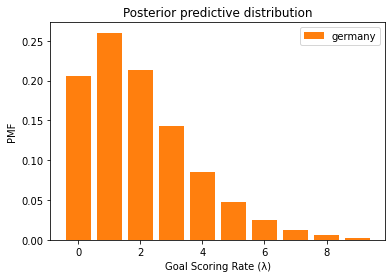

In [57]:
pred_germany2.bar(color='C1', label='germany')
plt.title('Posterior predictive distribution')
plt.xlabel('Goal Scoring Rate (λ)')
plt.ylabel('PMF')
plt.legend()

In [58]:

# Here's the probability of scoring exactly 5 more goals

pred_germany2[5]

0.047109658706113416

In [61]:
# And the probability of 5 or more

pred_germany2.prob_ge(5)

0.09286200122834538

### **Exercise -2:**
Returning to the first version of the World Cup Problem. Suppose France and Croatia play a rematch. What is the probability that France scores first?

Hint: Compute the posterior predictive distribution for the time until the first goal by making a mixture of exponential distributions. You can use the following function to make a PMF that approximates an exponential distribution.

In [63]:
def make_expo_pmf(lam, high):
    """Make a PMF of an exponential distribution.
    
    lam: event rate
    high: upper bound on the interval `t`
    
    returns: Pmf of the interval between events
    """
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [64]:
# Here are the predictive distributions for the 
# time until the first goal

pmf_seq = [make_expo_pmf(lam, high=4) for lam in prior.qs]

In [65]:
# And here are the mixtures based on the two posterior distributions

pred_france = make_mixture(france, pmf_seq)
pred_croatia = make_mixture(croatia, pmf_seq)

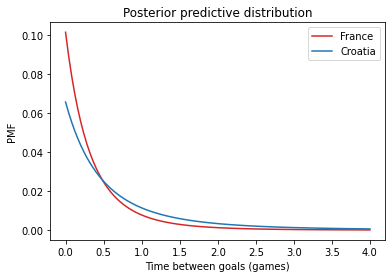

In [67]:
# Here's what the posterior predictive distributions look like

pred_france.plot(label='France', color='C3')
pred_croatia.plot(label='Croatia', color='C0')

decorate_time('Posterior predictive distribution')
plt.legend()

In [68]:
# And here's the probability France scores first

Pmf.prob_lt(pred_france, pred_croatia)

0.5904596116867543

### **Exercise:** 

In the 2010-11 National Hockey League (NHL) Finals, my beloved Boston Bruins played a best-of-seven championship series against the despised Vancouver Canucks. Boston lost the first two games 0-1 and 2-3, then won the next two games 8-1 and 4-0. At this point in the series, what is the probability that Boston will win the next game, and what is their probability of winning the championship?

To choose a prior distribution, I got some statistics from http://www.nhl.com, specifically the average goals per game for each team in the 2010-11 season. The distribution is well modeled by a gamma distribution with mean 2.8.

In what ways do you think the outcome of these games might violate the assumptions of the Poisson model? How would these violations affect your predictions?

In [69]:
from scipy.stats import gamma

alpha = 2.8
qs = np.linspace(0, 15, 101)
ps = gamma.pdf(qs, alpha)
prior_hockey = Pmf(ps, qs)
prior_hockey.normalize()

6.666325137469514

2.7997400090376567

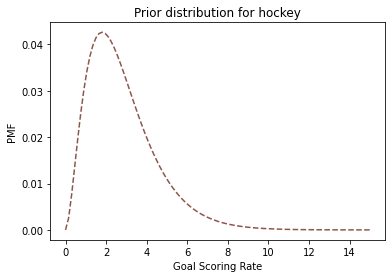

In [72]:
prior_hockey.plot(ls='--', color='C5')
plt.title('Prior distribution for hockey')
plt.xlabel('Goal Scoring Rate')
plt.ylabel('PMF')
prior_hockey.mean()

In [73]:
bruins = prior_hockey.copy()
for data in [0, 2, 8, 4]:
    update_poisson(bruins, data)
    
bruins.mean()

3.3599999999999985

In [74]:
canucks = prior_hockey.copy()
for data in [1, 3, 1, 0]:
    update_poisson(canucks, data)
    
canucks.mean()

1.5599999606443666

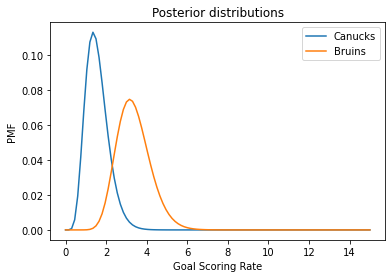

In [76]:
canucks.plot(label='Canucks')
bruins.plot(label='Bruins')

plt.title('Posterior distributions')
plt.xlabel('Goal Scoring Rate')
plt.ylabel('PMF')
plt.legend()

In [77]:
# Solution

goals = np.arange(15)
pmf_seq = [make_poisson_pmf(lam, goals) for lam in bruins.qs]

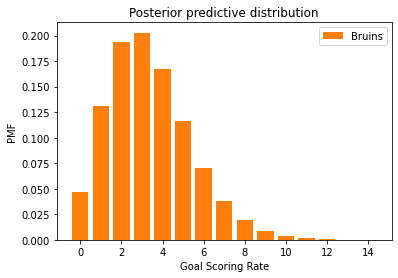

In [79]:
pred_bruins = make_mixture(bruins, pmf_seq)

pred_bruins.bar(label='Bruins', color='C1')
plt.title('Posterior predictive distribution')
plt.xlabel('Goal Scoring Rate')
plt.ylabel('PMF')
plt.legend()

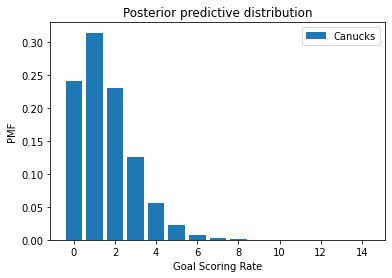

In [80]:
pred_canucks = make_mixture(canucks, pmf_seq)
pred_canucks.bar(label='Canucks')
plt.title('Posterior predictive distribution')
plt.xlabel('Goal Scoring Rate')
plt.ylabel('PMF')
plt.legend()

In [81]:
win = Pmf.prob_gt(pred_bruins, pred_canucks)
lose = Pmf.prob_lt(pred_bruins, pred_canucks)
tie = Pmf.prob_eq(pred_bruins, pred_canucks)

win, lose, tie

(0.7038631514645926, 0.16111690750716465, 0.1350199410282429)

In [82]:
p = win + tie/2
p

0.771373121978714

In [83]:
from scipy.stats import binom

n = 3
a = binom.pmf([2,3], n, p)
a.sum()

0.8670900197850085